<a href="https://www.kaggle.com/code/alexeybulichev/telecommunications?scriptVersionId=190500599" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Описание проекта: Телекоммуникации**

Оператор связи «ТелеДом» стремится уменьшить отток клиентов. Для этого его сотрудники планируют предлагать промокоды и специальные условия всем, кто собирается отказаться от услуг связи. Чтобы заранее выявлять таких пользователей, «ТелеДому» нужна модель, которая сможет предсказывать, разорвет ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, а также информацию об их тарифах и услугах.

Цель проекта — обучить модель на этих данных для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

* Стационарная телефонная связь: телефон можно подключить к нескольким линиям одновременно.

* Интернет: подключение может быть двух типов — через телефонную линию (DSL, digital subscriber line) или оптоволоконный кабель (Fiber optic).

**Дополнительные услуги включают:**

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут оплачивать услуги ежемесячно или заключить договор на 1–2 года. Оплата возможна различными способами, включая получение электронного чека.

**Цель работы**

Создать модель для предсказания оттока клентов, узнать какие признакие признаки на это влияют.




# **Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

**contract_new.csv — Информация о договоре**

* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты (ежемесячно или ежегодно);
* PaperlessBilling — электронный расчетный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

**personal_new.csv — Персональные данные клиента**

* customerID — идентификатор пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

**internet_new.csv — Информация об интернет-услугах**

* customerID — идентификатор пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

**phone_new.csv — Информация об услугах телефонии**

* customerID — идентификатор пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 01 февраля 2020 года.

#  Загрузка данных

In [1]:
! pip install phik -q;
! pip install catboost -q;
! pip install shap -q;

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler)

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.compose import ColumnTransformer

from sklearn.metrics import  accuracy_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import PolynomialFeatures

from catboost import CatBoostClassifier

from sklearn.impute import SimpleImputer

from sklearn.datasets import make_classification

from sklearn.pipeline import Pipeline

import shap

import phik

from time import time

sns.set_style('darkgrid')
sns.set(font_scale=1.3)

In [3]:
try:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
except:
    print('Невозможно загрузить файл contract_new.csv')
else:
    print('Файл contract_new.csv загружен')

try:
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
except:
    print('Невозможно загрузить файл personal_new.csv')
else:
    print('Файл personal_new.csv загружен')

try:
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
except:
    print('Невозможно загрузить файл internet_new.csv')
else:
    print('Файл internet_new.csv загружен')

try:
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
except:
    print('Невозможно загрузить файл phone_new.csv')
else:
    print('Файл phone_new.csv загружен')

Файл contract_new.csv загружен
Файл personal_new.csv загружен
Файл internet_new.csv загружен
Файл phone_new.csv загружен


#  Исследовательский анализ и предобработка данных

Для начала приведем все буквы к нижнему регистру.

In [4]:
#  Приводим все буквы к нижнему регистру
contract = contract.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
contract.columns = contract.columns.str.lower()

personal = personal.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
personal.columns = personal.columns.str.lower()

internet = internet.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
internet.columns = internet.columns.str.lower()

phone = phone.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
phone.columns = phone.columns.str.lower()

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Переименуем некоторые столбцы для удобства.

In [5]:
contract = contract.rename(columns={'customerid': 'customer_id',
                                    'begindate': 'begin_date',
                                    'enddate': 'end_date',
                                    'type': 'contract_type',
                                    'paperlessbilling': 'paperless_billing',
                                    'paymentmethod': 'payment_method',
                                    'monthlycharges': 'monthly_charges',
                                    'totalcharges': 'total_charges'
                                    }
                           )
personal = personal.rename(columns={'customerid': 'customer_id',
                                    'seniorcitizen': 'senior_citizen'
                                    }
                           )
internet = internet.rename(columns={'customerid': 'customer_id',
                                    'internetservice' : 'internet_service',
                                    'onlinesecurity': 'online_security',
                                    'onlinebackup': 'online_backup',
                                    'deviceprotection': 'device_protection',
                                    'techsupport' : 'tech_support',
                                    'streamingtv': 'streaming_tv',
                                    'streamingmovies': 'streaming_movies'
                                    }
                           )

phone = phone.rename(columns={'customerid': 'customer_id',
                                    'multiplelines': 'multiple_lines'
                                    }
                           )

Выведем информацию и по пять строк каждого Датафрейма.

In [6]:
print(contract.info())
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   contract_type      7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.6
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.5


In [7]:
print(personal.info())
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customer_id,gender,senior_citizen,partner,dependents
0,7590-vhveg,female,0,yes,no
1,5575-gnvde,male,0,no,no
2,3668-qpybk,male,0,no,no
3,7795-cfocw,male,0,no,no
4,9237-hqitu,female,0,no,no


In [8]:
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-vhveg,dsl,no,yes,no,no,no,no
1,5575-gnvde,dsl,yes,no,yes,no,no,no
2,3668-qpybk,dsl,yes,yes,no,no,no,no
3,7795-cfocw,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,fiber optic,no,no,no,no,no,no


In [9]:
print(phone.info())
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customer_id,multiple_lines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes


Датафреймы читаются коректно. Общее количество строк в каждом Датафрейме отличается. Одинаковое количество строк только в Датафреймах `contract` и `personal`, по 7043 строки. В Датафрейме `internet` 5517 строк, а в `phone` 6361. Возможно, что некоторые пользователи пользуется только услугами телефонии без интернета и наоборот интернетом без телефонии.

Изменим типы данных в Датафреймах.

Изменение типа данных Датафрейма `contract`:

* Изменим тип данных у столбца `begin_date` на `datetime64`.
* Столбец `total_charges` переведем в формат `float64`, так же есть столбец `monthly_charges`, который уже в формате `float64`.
* Cтолбцы `contract_type`, `paperless_billing`, `payment_method` и `customer_id` оставим как в формате `object`.
* Столбец `end_date` оставим без изменений, поскольку это целевой признак, его мы обработаем чуть позже.

В остальных датасетах менять тип данных не будем, там все корректно.


In [10]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])


contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

Выведем все уникальные значения каждого столбца кроме числовых и столбцов с датами во всех Датафреймах для просмотра коректности написания значений и посика неявных дубликатов.

In [11]:
contract_columns = ['contract_type', 'paperless_billing', 'payment_method']
for i in contract_columns:
    print(f"Наименование столбца: {i}\n\nУникальные значения: {contract[i].unique()}\n\nКоличество уникальных значений: {contract[i].nunique()}")
    print('-'*50)

Наименование столбца: contract_type

Уникальные значения: ['month-to-month' 'one year' 'two year']

Количество уникальных значений: 3
--------------------------------------------------
Наименование столбца: paperless_billing

Уникальные значения: ['yes' 'no']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: payment_method

Уникальные значения: ['electronic check' 'mailed check' 'bank transfer (automatic)'
 'credit card (automatic)']

Количество уникальных значений: 4
--------------------------------------------------


In [12]:
internet_columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for i in internet_columns:
    print(f"Наименование столбца: {i}\n\nУникальные значения: {internet[i].unique()}\n\nКоличество уникальных значений: {internet[i].nunique()}")
    print('-'*50)

Наименование столбца: internet_service

Уникальные значения: ['dsl' 'fiber optic']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: online_security

Уникальные значения: ['no' 'yes']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: online_backup

Уникальные значения: ['yes' 'no']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: device_protection

Уникальные значения: ['no' 'yes']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: tech_support

Уникальные значения: ['no' 'yes']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: streaming_tv

Уникальные значения: ['no' 'yes']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: streaming_movies

Ун

In [13]:
phone_columns = ['multiple_lines']
for i in phone_columns:
    print(f"Наименование столбца: {i}\n\nУникальные значения: {phone[i].unique()}\n\nКоличество уникальных значений: {phone[i].nunique()}")
    print('-'*50)

Наименование столбца: multiple_lines

Уникальные значения: ['no' 'yes']

Количество уникальных значений: 2
--------------------------------------------------


In [14]:
personal_columns = ['gender', 'senior_citizen', 'partner', 'dependents']
for i in personal_columns:
    print(f"Наименование столбца: {i}\n\nУникальные значения: {personal[i].unique()}\n\nКоличество уникальных значений: {personal[i].nunique()}")
    print('-'*50)

Наименование столбца: gender

Уникальные значения: ['female' 'male']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: senior_citizen

Уникальные значения: [0 1]

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: partner

Уникальные значения: ['yes' 'no']

Количество уникальных значений: 2
--------------------------------------------------
Наименование столбца: dependents

Уникальные значения: ['no' 'yes']

Количество уникальных значений: 2
--------------------------------------------------


В Датасетах отсутствуют неявные дубликаты, но необходимо заменить некоторые значения для удобства.

Изменим значения в Датафрейме `contract`:

* В столбце `contract_type` изменим значение `month-to-month` на `mtm`, `one year` на `one_year` и `two year` на `two_year`.

* В столбце `payment_method` значения `electronic check`, `mailed check`, `bank transfer (automatic)` и `credit card (automatic)`, вместо пробелов поставим `_`.

In [15]:
contract['contract_type'] = contract['contract_type'].replace(' ', '_', regex=True)
contract['payment_method'] = contract['payment_method'].replace(' ', '_', regex=True)
contract['contract_type'] = contract['contract_type'].replace('month-to-month', 'mtm', regex=True)

internet['internet_service'] = internet['internet_service'].replace(' ', '_', regex=True)

**Итоговый вывод по проекту оттока клиентов**

Приведение данных к нижнему регистру:

* Все буквы приведены к нижнему регистру для унификации данных.

Переименование столбцов:

* Некоторые столбцы переименованы для удобства работы и анализа.

Чтение датафреймов:

* Все датафреймы были успешно прочитаны.
* Общее количество строк в каждом датафрейме различается.
* Датафреймы contract и personal содержат по 7043 строки.
* Датафрейм internet содержит 5517 строк.
* Датафрейм phone содержит 6361 строку.
* Возможно, некоторые пользователи пользуются только телефонными услугами без интернета и наоборот.

Изменение типов данных:

В датафрейме contract были изменены типы данных:
* Столбец begin_date переведен в формат datetime64.
* Столбец total_charges переведен в формат float64.
* Столбец monthly_charges уже был в формате float64.
* Столбцы contract_type, paperless_billing, payment_method и customer_id оставлены в формате object.
* Столбец end_date оставлен без изменений, так как является целевым признаком и будет обработан позже.
* В остальных датасетах типы данных корректны и не требуют изменений.

Проверка уникальных значений:

* Были выведены уникальные значения каждого столбца (кроме числовых и столбцов с датами) для проверки корректности написания значений и поиска неявных дубликатов.
* В датасетах отсутствуют неявные дубликаты, но некоторые значения требуют замены для удобства.

Замена значений:

В датафрейме contract:
* В столбце contract_type:
* month-to-month заменено на mtm.
* one year заменено на one_year.
* two year заменено на two_year.

В столбце payment_method значения изменены:
* electronic check, mailed check, bank transfer (automatic) и credit card (automatic) заменены на аналогичные значения с _ вместо пробелов.

# Объединение данных в один Датафрейм и обработка финального Датафрейма

Обеденим все данные в один Датафрейм, все будем поочередно присоеденять к Датафрейму `personal`.

In [16]:
data = personal.merge(contract, on='customer_id', how='left')
data = data.merge(internet, on='customer_id', how='left')
data = data.merge(phone, on='customer_id', how='left')

In [17]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   object        
 7   contract_type      7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7032 non-null   float64       
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-vhveg,female,0,yes,no,2020-01-01,no,mtm,yes,electronic_check,29.85,31.04,dsl,no,yes,no,no,no,no,NaN
1,5575-gnvde,male,0,no,no,2017-04-01,no,one_year,no,mailed_check,56.95,2071.84,dsl,yes,no,yes,no,no,no,no
2,3668-qpybk,male,0,no,no,2019-10-01,no,mtm,yes,mailed_check,53.85,226.17,dsl,yes,yes,no,no,no,no,no
3,7795-cfocw,male,0,no,no,2016-05-01,no,one_year,no,bank_transfer_(automatic),42.30,1960.60,dsl,yes,no,yes,yes,no,no,NaN
4,9237-hqitu,female,0,no,no,2019-09-01,no,mtm,yes,electronic_check,70.70,353.50,fiber_optic,no,no,no,no,no,no,no


Все данные объеденены корректно. Количество строк в итоговом Датафрейме составляет 7043 строки, что равно количеству клиентов из Датафрейма `personal`.

Проверим объедененый Датафрейм `data` на наличие пропусков.

Количество пропусков в data:
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
total_charges          11
dtype: int64


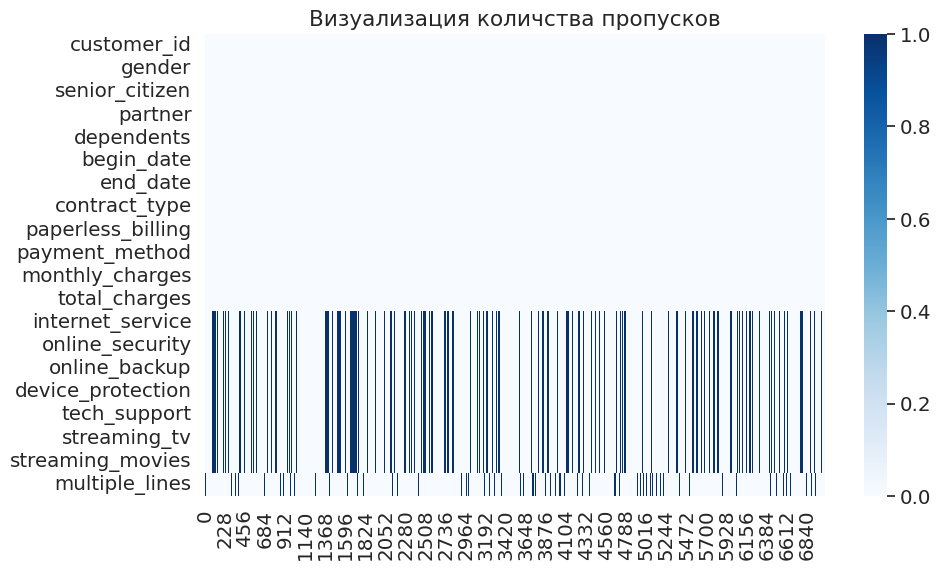

In [18]:
print(f'Количество пропусков в data:\n{data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False)}')
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna().transpose(), cmap='Blues')
plt.title('Визуализация количства пропусков')
plt.show()

В столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`,`tech_support`, `streaming_tv` и `streaming_movies` найдено 1526 пропусков, в солбце `multiple_lines` 682 пропуска, а в `total_charges` 11 пропусков.

Поступим следющим образом:

* Заменим пропуска из столбца `internet_service` на заглушку `no` поскольку после объеденения таблиц, у некоторых клиентов отутствует информация о виде подключения интернета, поскольку у них подключена только телефония, поэтому у них банально не подключена эта услуга.

* Аналогичным образом поступим со столбцами `online_security`, `online_backup`, `device_protection`,`tech_support`, `streaming_tv`? `multiple_lines` и `streaming_movies`, заменим пропуска на `no`.

* Столбец `total_charges` проверим на наличие оплат. Возможно клиенты только подключились к сервису и неуспели произвести оплату.



In [19]:
query_total_data = data.query('total_charges.isna()')
query_total_data['begin_date']

488    2020-02-01
753    2020-02-01
936    2020-02-01
1082   2020-02-01
1340   2020-02-01
3331   2020-02-01
3826   2020-02-01
4380   2020-02-01
5218   2020-02-01
6670   2020-02-01
6754   2020-02-01
Name: begin_date, dtype: datetime64[ns]

Теория подтвердилась. Клиенты с пропусками в столбце `total_charges` только подключились к сервису, а данные актуальны на 01 февраля 2020 года. Поэтому заменим все пропуска на 0.

Количество пропусков в data:
Series([], dtype: int64)


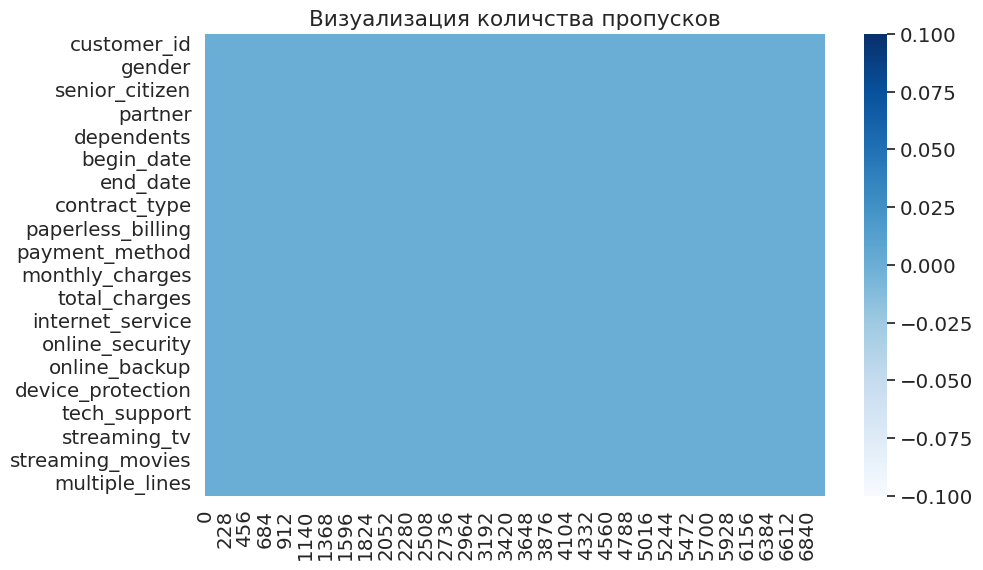

In [20]:
data['total_charges'] = data['total_charges'].fillna(0)
data = data.fillna('other')

print(f'Количество пропусков в data:\n{data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False)}')
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna().transpose(), cmap='Blues')
plt.title('Визуализация количства пропусков')
plt.show()

Отлично! Пропусков неосталоси и получилось сохранить все данные для дальнейшей работы.

**Вывод объединение данных и обработка пропусков**

Объединение данных в один датафрейм:

* Все данные объединены в один датафрейм, начиная с personal и поочередно присоединяя к нему остальные данные.
* Итоговый датафрейм содержит 7043 строки, что соответствует количеству клиентов в датафрейме personal.

Проверка объединенного датафрейма на наличие пропусков:

Пропуски найдены в следующих столбцах:

* internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv и streaming_movies – 1526 пропусков.
* multiple_lines – 682 пропуска.
* total_charges – 11 пропусков.

Обработка пропусков:

*Пропуски в столбцах internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, multiple_lines и streaming_movies:
* Заменены на other, поскольку эти услуги отсутствуют у клиентов, которые пользуются только телефонией.

Пропуски в столбце total_charges:

* Проверено, что клиенты с пропусками только что подключились к сервису и еще не произвели оплату.
* Пропуски заменены на 0, что подтверждает отсутствие оплаты у новых клиентов на 1 февраля 2020 года.

Итог:

* Пропуски успешно обработаны.
* Данные сохранены в полном объеме для дальнейшей работы.

# Создание новых признаков

Поскольку задача у нас состоит предсказать расторгнет клиент Договор или нет, необходимо создать целевой бинарный признак, где 0 это клиент рассторгнул договор, а 0 нет. Для создания целевого признака, возьмем за основу столбец `end_date`, где указаны даты расторжения Договора и обозначение `no`, где клиент не расторгнул договор. Сдераем все значения `no` == 1, а остальные 0, поскольку клиенты расторгнули Договор.

In [21]:
data['target'] = (data['end_date'] != 'no').astype('object')

Так же изменим признак `begin_date`, поскольку дата заключения договора нам ничего не говорит, а вот период действия договора может пригодится и назомем его `period_contract`.

In [22]:
now_date = pd.to_datetime('2020-02-01')
data['end_date'] = data['end_date'].replace('no', now_date).astype('datetime64[ns]')
data['period_contract'] = (data['end_date'] - data['begin_date']).dt.days
data.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,contract_type,paperless_billing,payment_method,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period_contract
0,7590-vhveg,female,0,yes,no,2020-01-01,2020-02-01,mtm,yes,electronic_check,...,dsl,no,yes,no,no,no,no,other,False,31
1,5575-gnvde,male,0,no,no,2017-04-01,2020-02-01,one_year,no,mailed_check,...,dsl,yes,no,yes,no,no,no,no,False,1036
2,3668-qpybk,male,0,no,no,2019-10-01,2020-02-01,mtm,yes,mailed_check,...,dsl,yes,yes,no,no,no,no,no,False,123
3,7795-cfocw,male,0,no,no,2016-05-01,2020-02-01,one_year,no,bank_transfer_(automatic),...,dsl,yes,no,yes,yes,no,no,other,False,1371
4,9237-hqitu,female,0,no,no,2019-09-01,2020-02-01,mtm,yes,electronic_check,...,fiber_optic,no,no,no,no,no,no,no,False,153


Отлично! Мы имеем два новых признака, целевой (1 - договор не расторгнут, 0 - договор расторгнут) и период действия договора в днях с момента заключения по 01 февраля 2020 года. Далее переименуем целевой признак с `end_date` на `target`, а признак `begin_date` удалим из за ненадобности.

In [23]:
data = data.drop(['begin_date', 'end_date'], axis = 1)

In [24]:
data.head()

,customer_id,gender,senior_citizen,partner,dependents,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period_contract
0,7590-vhveg,female,0,yes,no,mtm,yes,electronic_check,29.85,31.04,dsl,no,yes,no,no,no,no,other,False,31
1,5575-gnvde,male,0,no,no,one_year,no,mailed_check,56.95,2071.84,dsl,yes,no,yes,no,no,no,no,False,1036
2,3668-qpybk,male,0,no,no,mtm,yes,mailed_check,53.85,226.17,dsl,yes,yes,no,no,no,no,no,False,123
3,7795-cfocw,male,0,no,no,one_year,no,bank_transfer_(automatic),42.30,1960.60,dsl,yes,no,yes,yes,no,no,other,False,1371
4,9237-hqitu,female,0,no,no,mtm,yes,electronic_check,70.70,353.50,fiber_optic,no,no,no,no,no,no,no,False,153


Теперь проверим данные на наличие явных дубликавтов исключив столбец 	`customer_id` сделав его индексом. Но для начала проверим является ли каждый `customer_id` уникальным.

In [25]:
if (data['customer_id'].nunique() == data.shape[0]) == True:
    print('Все customer_id уникальны.')
else:
    print('Есть повторяющиеся customer_id.')

Все customer_id уникальны.


Отлично, каждый `costumer_id` уникальный, сделаем его индексом и проверим весь Датасет на явные дубликаты.

In [26]:
#Функция для удаления дубликатов
def duplicat(data):
    print(f'Размер Датафрейма с дубликатами {data.shape}')
    print(f'Количество строк дубликатов: {data.duplicated ().sum()}')
    print(f'Процентное соотноешение пропусков: {round(data.duplicated().sum() / len(data) *100, 2)}%')
    return

In [27]:
data.set_index('customer_id', inplace=True)

In [28]:
duplicat(data)

Размер Датафрейма с дубликатами (7043, 19)
Количество строк дубликатов: 4
Процентное соотноешение пропусков: 0.06%


Надено 4 явных дубликата, это 0.06% от всего Датасета. Поскольку это незначительная потеря данных, удалим эти дубликаты.

In [29]:
data = data.drop_duplicates().reset_index(drop=True)

** Вывод создания новых признаков и проверка данных**

Создание целевого признака:

* Задача состоит в предсказании, расторгнет ли клиент договор.
Новый целевой бинарный признак создается на основе столбца end_date:
* Значения no (клиент не расторг договор) заменяются на 1. Остальные значения (даты расторжения договора) заменяются на 0.
* Столбец end_date переименовывается в target.

Создание признака периода действия договора:

Изменяем столбец begin_date:

* Период действия договора вычисляется как разница между датой заключения договора и 1 февраля 2020 года.
* Новый признак называется period_contract.
* Столбец begin_date удаляется за ненадобностью.

Проверка уникальности customer_id:

* Проверяем, является ли каждый customer_id уникальным.
* Каждый customer_id уникален, поэтому делаем его индексом датафрейма.

Проверка и удаление явных дубликатов:

* Проверка всего датасета на наличие явных дубликатов (исключая столбец customer_id).
* Найдено 4 явных дубликата (0.06% от всего датасета).
* Эти дубликаты удалены, так как их удаление незначительно влияет на общие данные.

# Анализ данных

In [30]:
def plot_categorical_data(data, num_col, hue=None):
    num_features = len(num_col)
    num_columns = 3
    num_rows = (num_features // num_columns) + (num_features % num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(num_col):
        plot = sns.countplot(x=feature, data=data, ax=axes[i], hue=hue)
        axes[i].set_title(f"График для {feature}")
        axes[i].grid(True)
        axes[i].set_xticks(axes[i].get_xticks())
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

        # Добавление значений на каждый бар
        for p in plot.patches:
            height = p.get_height()
            axes[i].annotate(format(height, '.2f'),
                             (p.get_x() + p.get_width() / 2., height),
                             ha = 'center', va = 'center',
                             xytext = (0, 4),  # Вертикальный отступ
                             textcoords = 'offset points')

    # Удаление пустых подграфиков
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [31]:
def plot_numeric_data(data, num_col, hue=None):
    num_features = len(num_col)
    num_columns = 3
    num_rows = (num_features // num_columns) + (num_features % num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(num_col):
        plot = sns.histplot(data=data, x=feature, hue=hue, ax=axes[i])
        axes[i].set_title(f"График для {feature}")
        axes[i].grid(True)
        axes[i].set_xticks(axes[i].get_xticks())
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

    # Удаление пустых подграфиков
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [32]:
def plot_box_data(data, num_col):
    num_features = len(num_col)
    num_columns = 3
    num_rows = (num_features // num_columns) + (num_features % num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(num_col):
        sns.boxplot(y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Boxplot for {feature}')
        axes[i].grid(True)

    # Удаление пустых подграфиков
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Сначала помтроим графики для категориальных данных. Предварительно разделив категориальны признаки от числоввых и сравним их значения что бы ничего не упустить.

In [33]:
data['senior_citizen'] = data['senior_citizen'].astype('object')

# Определяем количественные и категориальные признаки
num_col = data.select_dtypes(include=['number']).columns.tolist()
cat_col = data.select_dtypes(include=['object']).columns.tolist()

In [34]:
print(f"Количество числовых пизнаков: {len(num_col)}\nКоличество категориальных признаков: {len(cat_col)}")

Количество числовых пизнаков: 3
Количество категориальных признаков: 16


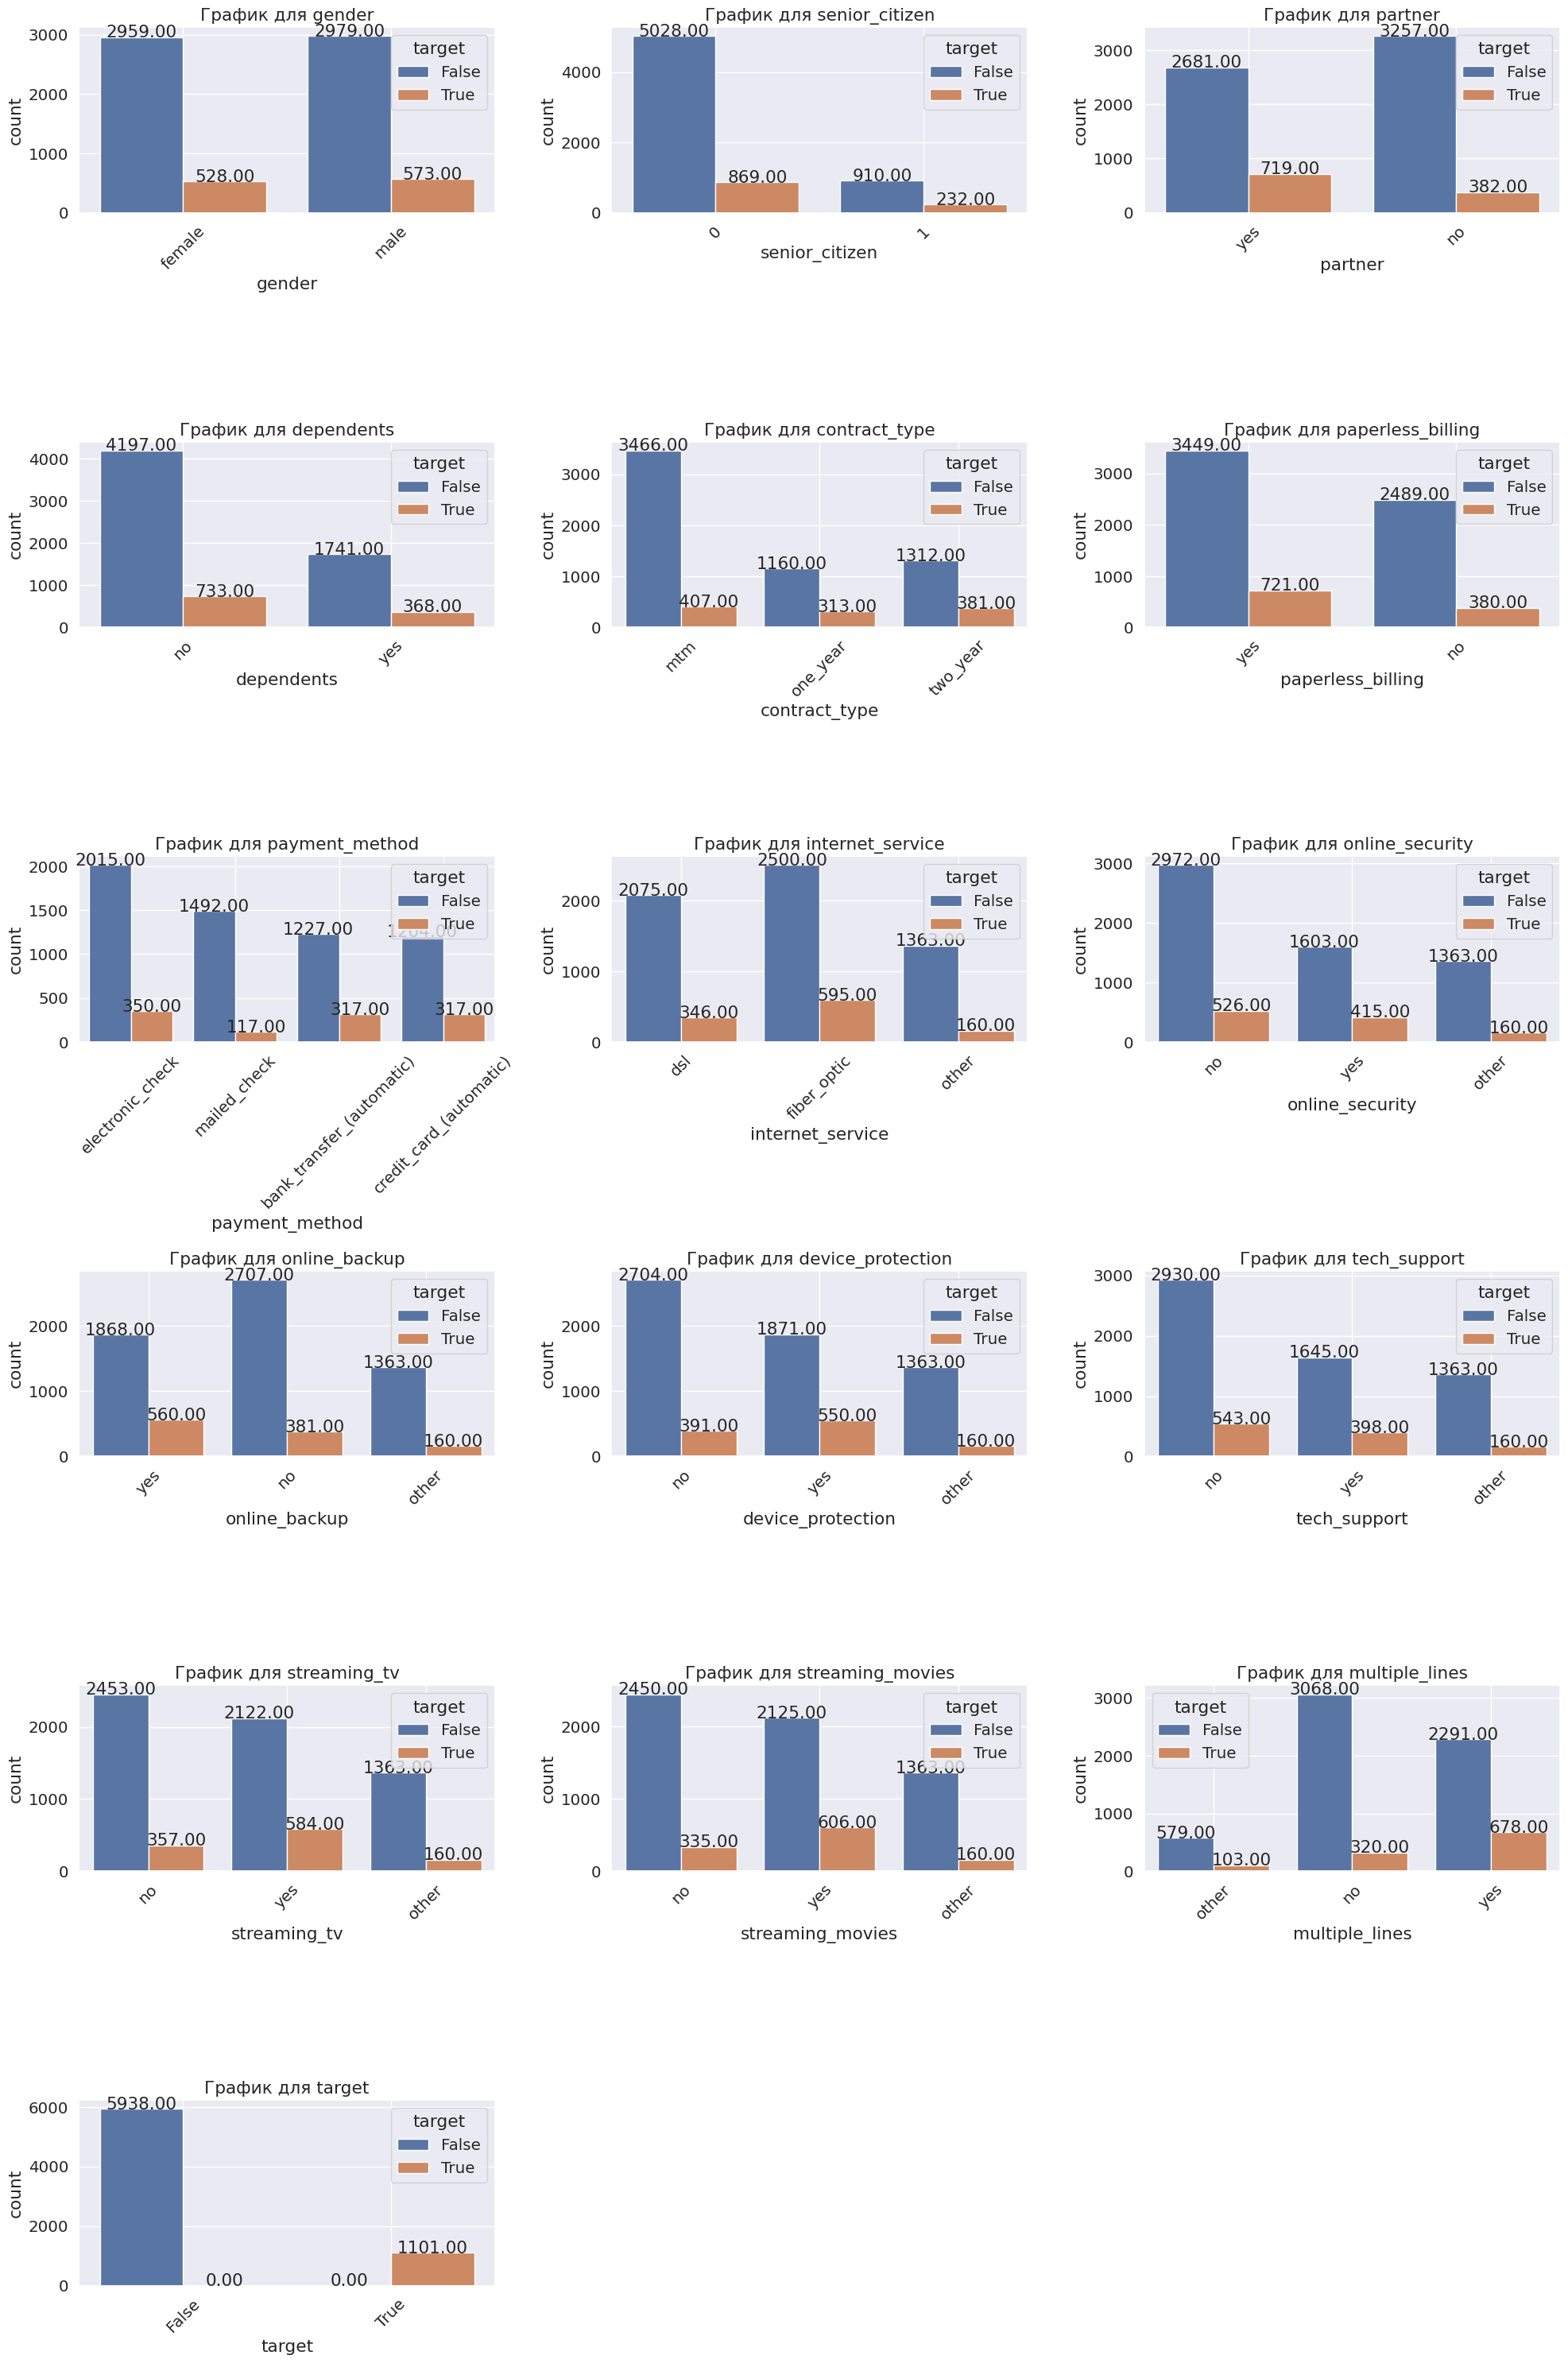

In [35]:
plot_categorical_data(data, cat_col, hue = 'target');

Анализ категориальных признаков:
* `gender` - в данных равное количество мужчин и женщин по 50% , тоже самое касается и разрыв договоров по 8%.

* `senior_citizen` - 83% клиентов не являются пенсионерами из них 12% расторгнули договор, в то время как  13% являются пенсионерами и 3% из них расторгнули договор.

* `partner` - 48% клиентов имеют супругу или супруга, 10% из которых расторгнули договор, оставшиеся 52% холосты 5% из которых расторгнули договор.

* `dependents` - у 70% клиентов есть деди и из них 10% отказались от услуг, а 25% без детей, из них 5% отказались от услуг.

* `target` (целевой признах) - от общего количества клиентов 16% отказались от услуг с компанией и здесь виден дисбаланс классов.

* `contract_type` - клиентов с ежемесячной оплатой больше всех, их 55% от общего количества всех клиентов, 6% из которых отказались от услуг компании. Клиентов с ежегодной составляет 20% и оплатой раз в два года 24%, среди которых примерно по 5% от общеого количества отказываются от подписки.

* `paperless_billing` - примерно 60% клиентов предпочитают электронный вид чека, 10% из которых отказались от услуг компании, а остальная часть клиентов получают неэлекторнные чеки, 5% из которых отказались от обслуживания.

* `payment_method` - 34% клиентов предпочитают оплату электронным чеком, 23% почтовым чеком, 22% автоматическим банковским переводом и автомотическим списанием с банковской карты.

* `internet_servise` - 24% используют цифровую абонентскую линию, 44% оптоволоконную линию и оставшаяся часть не использует интернет сервис.

* По остальным дополнительным интернет услугам, большая часть клиентов ими не пользуется.

Перейдем к числовым данным.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

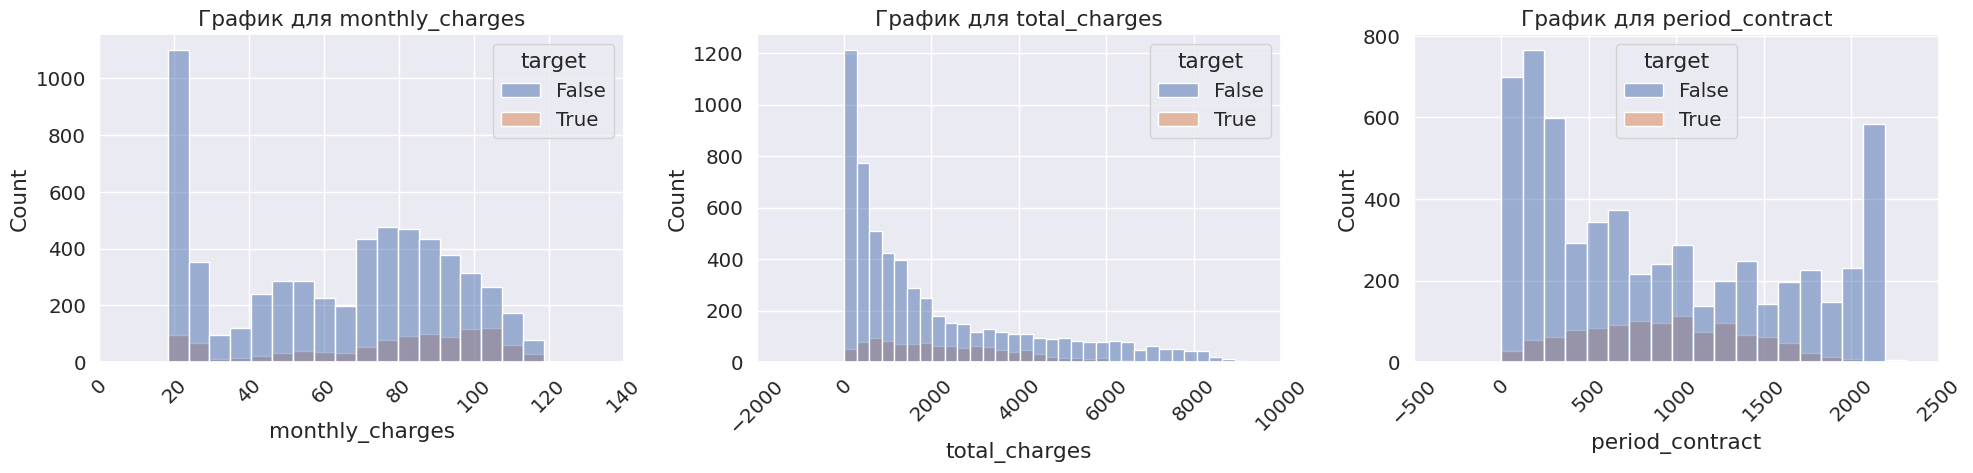

In [36]:
plot_numeric_data(data, num_col, hue = 'target')

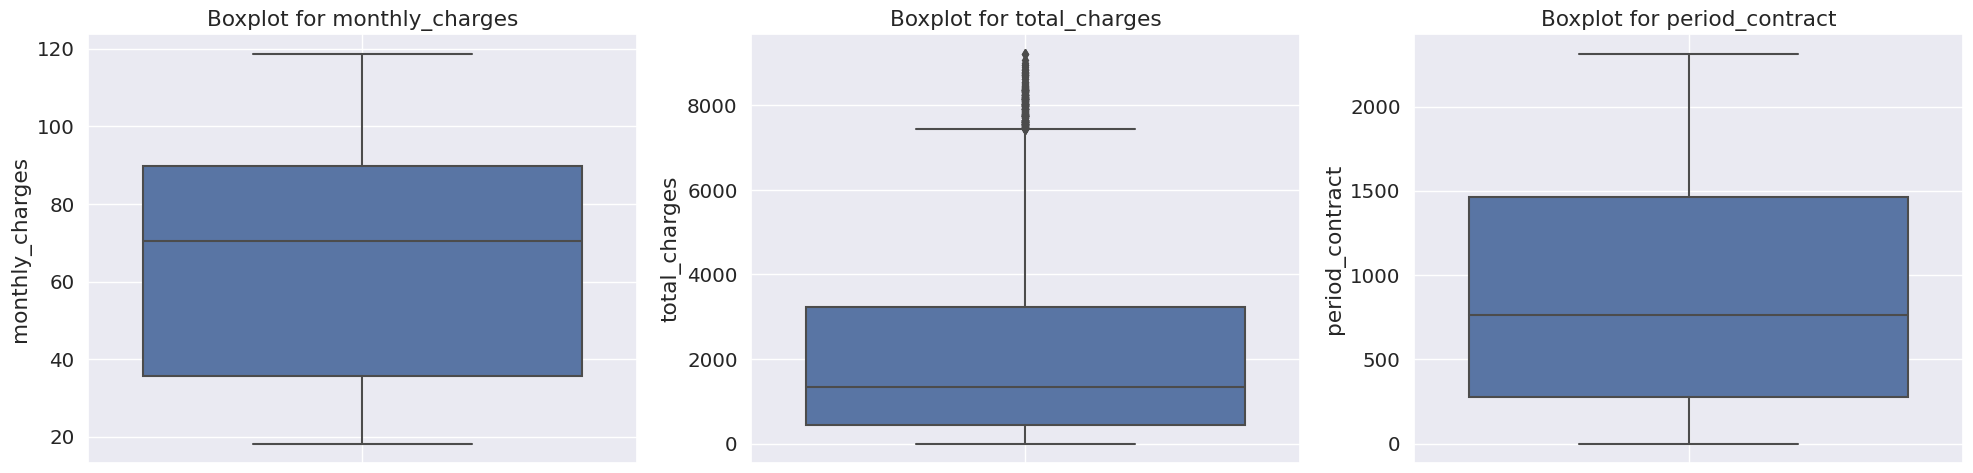

In [37]:
plot_box_data(data, num_col)

* `monthly_charges` - gримерно равномерное распределение значений, но видно преймущественное количество со значением 20.


* `total_charges` - преобладают более низкие значения, есть значительная часть клиентов с высокими значениями. Чем меньше значения, тем больше отказов от услуг компании.

* `period_contract` - значения распределены по всему диапазону от 0 до более чем 2000 дней. Чем дольше длится период договора, тем больше вероятность отказа от услуг компании.

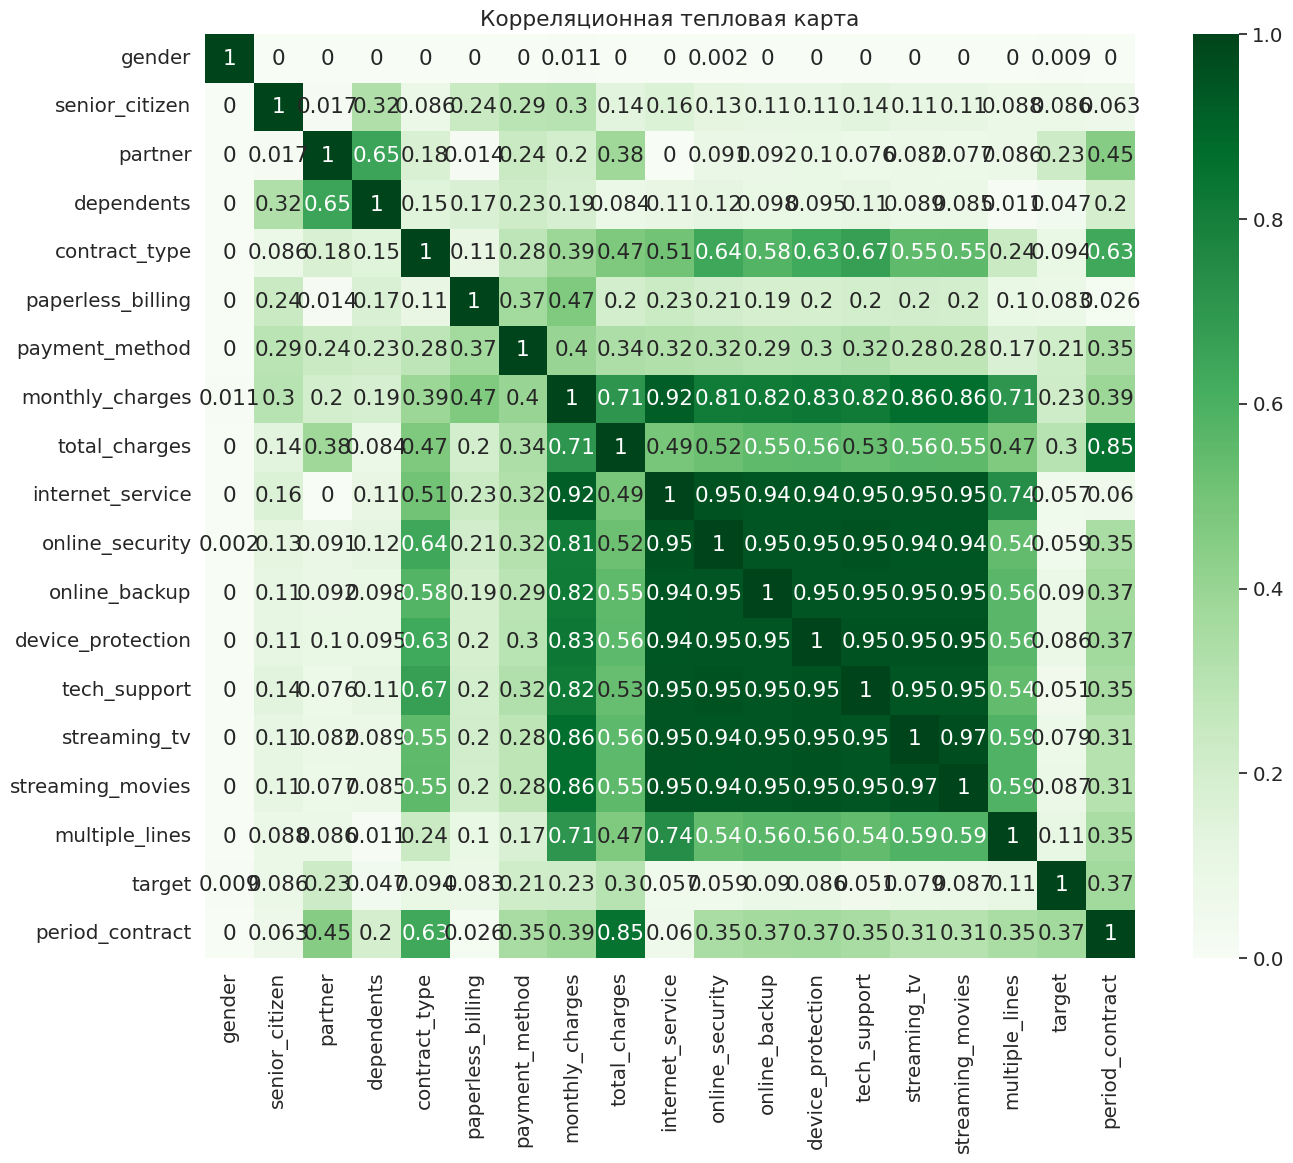

In [38]:
corr_matrix = phik_matrix(data, interval_cols = num_col)
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix , annot=True, cmap='Greens')
plt.title('Корреляционная тепловая карта')
plt.show()

При построении тепловой корреляционной карты, наблюдается мулькокоррелиальность среди интернет услуг компании, на каттегориальных графиках было заметно практически одинаковое значения у клиентов в данных услугах. С целевым значением `target` преймущественно коррелирует Период действия договора, чем дольше действует договор, тем больше вероятноть отказа от услуг компании. Посмотрим на тепловую карту, где значения корреляции целевого признака > 0.1.

In [39]:
threshold = 0.1

low_corr_features = corr_matrix.columns[corr_matrix['target'].abs() < threshold].tolist()

print(f"Признаки с корреляцией меньше {threshold}: {len(low_corr_features)} шт." )
print(low_corr_features)

Признаки с корреляцией меньше 0.1: 12 шт.
['gender', 'senior_citizen', 'dependents', 'contract_type', 'paperless_billing', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


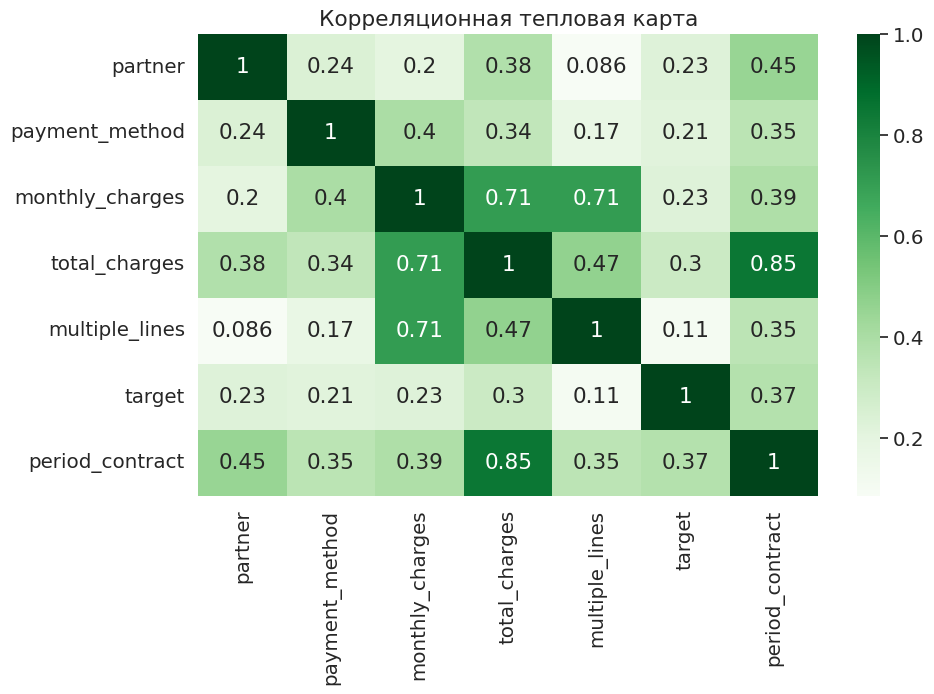

In [40]:
corr_matrix = phik_matrix(data.drop(low_corr_features, axis = 1), interval_cols = num_col)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix , annot=True, cmap='Greens')
plt.title('Корреляционная тепловая карта')
plt.show()

**Выводы анализа даных**

* gender: Равномерное распределение и одинаковый процент оттока между мужчинами и женщинами.
* senior_citizen: Пенсионеры менее склонны расторгать договоры.
* partner: Клиенты с супругами чаще расторгают договоры.
* dependents: Клиенты с детьми чаще расторгают договоры.
* contract_type: Клиенты с ежемесячной оплатой чаще расторгают договоры.
* paperless_billing: Предпочитающие электронные чеки чаще расторгают договоры.
* period_contract: Длительность договора имеет сильное влияние на отток; чем дольше клиент пользуется услугами, тем больше вероятность расторжения договора.

Корреляция

* period_contract: Самый значимый признак, коррелирующий с целевым значением (target).
* Интернет-услуги: Мультиколлинеарность между различными интернет-услугами.

Длительность договора и тип контракта играют ключевую роль в предсказании оттока клиентов. Остальные признаки также оказывают влияние, но менее значительное.

# Подготовка данных к обучению

In [41]:
cat_col.remove('target')
data['target'] = data['target'].astype('int')

In [42]:
RANDOM_STATE = 80724

test_size = 0.25

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis = 1),
                                                    data['target'],
                                                    test_size=test_size,
                                                    random_state=RANDOM_STATE)

In [43]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

num_pipe = Pipeline(
    [
        ('num', StandardScaler())
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col),
        ('ohe', ohe_pipe, cat_col)
    ]
)

# Определение окончательного пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [44]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'models__min_samples_split': range(2, 15)
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 300),
        'models__criterion': ['gini', 'entropy'],
        'models__max_depth': range(3, 30),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 5),
        'models__max_features': ['sqrt', 'log2'],
        'models__bootstrap': [True, False]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 5),
        'models__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
        'models__coef0': [0.0, 0.1, 0.5, 1.0]
    }
]

param_grid_lr = [
    {
        'models': [LogisticRegression()]
    }
]

param_grid_CBR = [
    {
        'models': [CatBoostClassifier(silent=True, random_state=RANDOM_STATE)],
        'models__iterations': [1000],
        'models__learning_rate': [0.1, 0.15, 0.2],
        'models__l2_leaf_reg': range(1, 8),
        'models__border_count': range(32, 100, 16),
        'models__bagging_temperature': [0, 0.5, 1, 2]
    }
]

In [45]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring = 'roc_auc',
    error_score='raise',
    random_state = RANDOM_STATE,
    n_jobs=-1,
    n_iter= 100,
    cv=5
)

randomized_search_lr = RandomizedSearchCV(
    pipe_final,
    param_grid_lr,
    scoring='roc_auc',
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100,
    cv=5
)

randomized_search_CBR = RandomizedSearchCV(
    pipe_final,
    param_grid_CBR,
    scoring='roc_auc',
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100,
    cv=5
)

In [46]:
randomized_search_CBR.fit(X_train, y_train);

In [47]:
randomized_search_lr.fit(X_train, y_train);

The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.


In [48]:
randomized_search.fit(X_train, y_train);

In [49]:
print('Лучшая модель и её параметры:\n\n', randomized_search_CBR.best_estimator_)
print('Метрика лучшей модели:', round(randomized_search_CBR.best_score_, 3))
print('Метрика лучшей модели:',randomized_search_CBR.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'period_contract']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'senior

In [50]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели:', round(randomized_search.best_score_, 3))
print('Метрика лучшей модели:',randomized_search.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'period_contract']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'senior

In [51]:
print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print('Метрика лучшей модели:', round(randomized_search_lr.best_score_, 3))
print('Метрика лучшей модели:',randomized_search_lr.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'period_contract']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'senior

In [52]:
best_model = randomized_search_CBR.best_estimator_

pred = best_model.predict_proba(X_test)[:,1]
print(f"Метрика тестовых данных: {round(roc_auc_score(y_test, pred), 3)}")

Метрика тестовых данных: 0.875


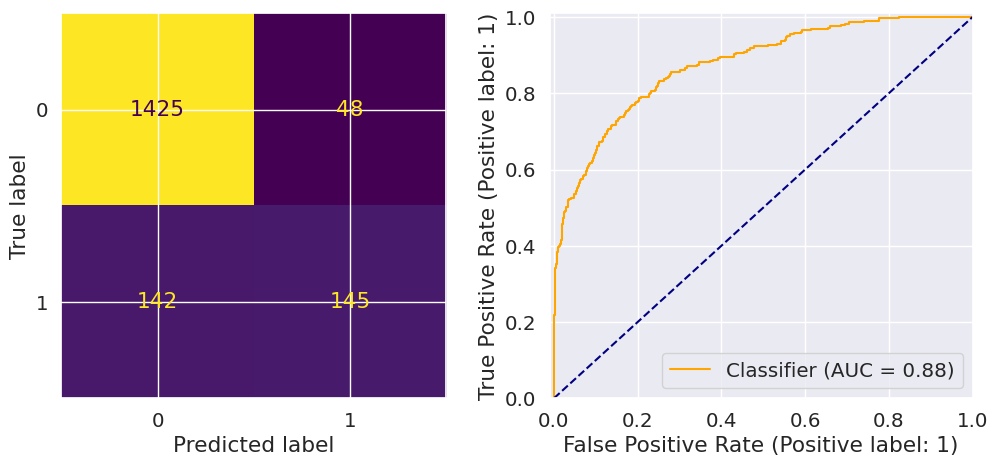

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1473
           1       0.75      0.51      0.60       287

    accuracy                           0.89      1760
   macro avg       0.83      0.74      0.77      1760
weighted avg       0.88      0.89      0.88      1760



In [53]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    colorbar=False,
)

RocCurveDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[1],
    color='orange',
)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_ylim(0, 1.01)
axes[1].set_xlim(-0.01, 1)

plt.show()

print(classification_report(y_test, y_pred))

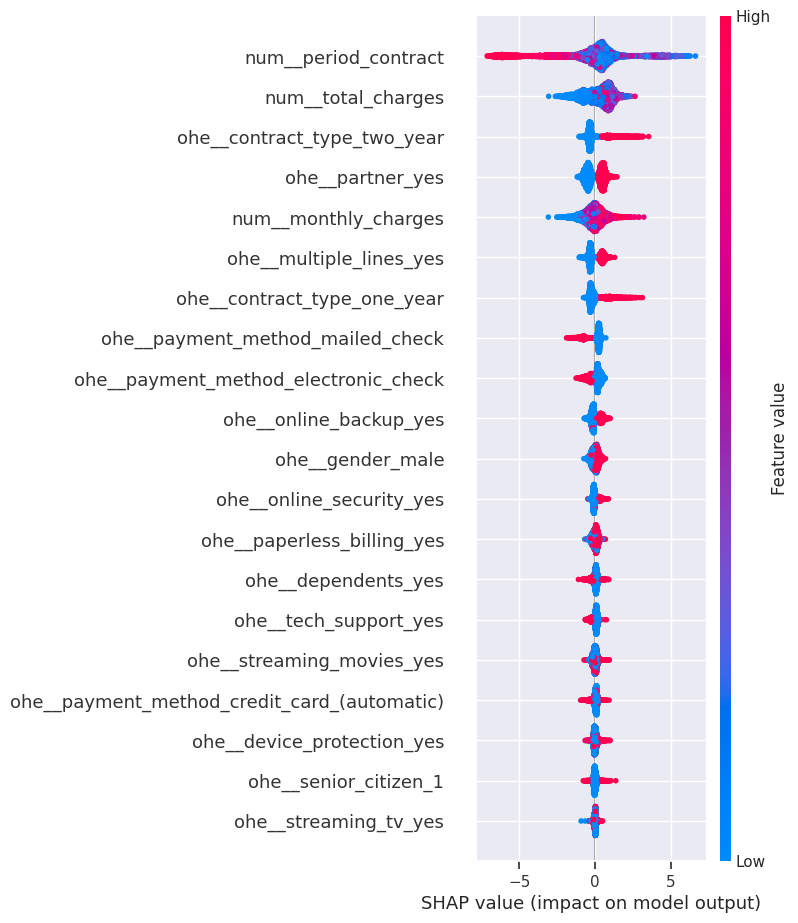

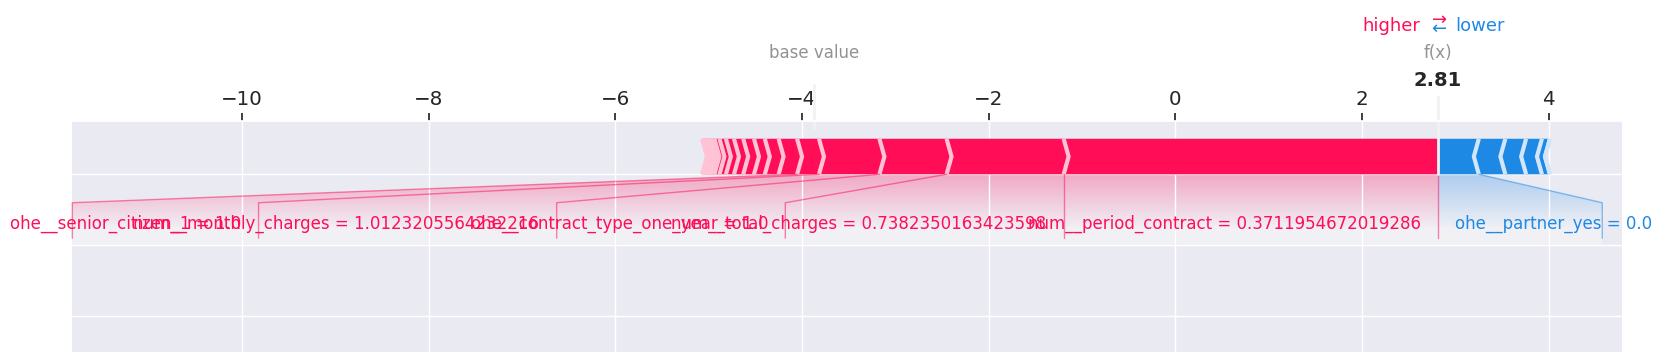

In [54]:
preprocessor = best_model.named_steps['preprocessor']
catboost_model = best_model.named_steps['models']
X_train_processed = preprocessor.transform(X_train)

feature_names = preprocessor.get_feature_names_out()

X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_train_processed_df)

shap.summary_plot(shap_values, X_train_processed_df)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X_train_processed_df.iloc[0], matplotlib=True)
plt.show()

Наибольшую важность для модели имеет признак `period_contract`. Также хотелось бы отметить значимость следующих за ним признаков  `monthly_charges` и `total_harges`. Остальные признаки менее значимы для модели

**Вывод обучения модели:**

Разделение данных:

* Данные разделены на обучающую и тестовую выборки с помощью train_test_split (75% обучение, 25% тест) с RANDOM_STATE = 80724.

Использовались различные модели классификации, настроенные с использованием RandomizedSearchCV для поиска лучших гиперпараметров:

**DecisionTreeClassifier:**
* max_depth: range(2, 15)
* max_features: range(2, 15)
* min_samples_leaf: range(2, 15)
* min_samples_split: range(2, 15)
* preprocessor__num: [StandardScaler(), 'passthrough']

**RandomForestClassifier:**
* n_estimators: range(100, 300)
* criterion: ['gini', 'entropy']
* max_depth: range(3, 30)
* min_samples_split: range(2, 11)
* min_samples_leaf: range(1, 5)
* max_features: ['auto', 'sqrt', 'log2']
* bootstrap: [True, False]
* preprocessor__num: [StandardScaler(), 'passthrough']

**CatBoostClassifier:**
* iterations: [100, 200, 300]
* learning_rate: [0.01, 0.1, 0.2, 0.3]
* l2_leaf_reg: range(1, 8)
* border_count: range(32, 100)
* bagging_temperature: range(0, 3)
* preprocessor__num: [StandardScaler(), 'passthrough']

**SVC:**
* C: [0.01, 0.1, 1, 10, 100]
* kernel: ['linear', 'poly', 'rbf', 'sigmoid']
* degree: range(2, 5)
* gamma: ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
* coef0: [0.0, 0.1, 0.5, 1.0]
* preprocessor__num: [StandardScaler(), 'passthrough']

**LogisticRegression (отдельный grid search):**
* penalty: ['l1', 'l2']
* C: [0.01, 0.1, 1, 10, 100]
* solver: ['saga']
* max_iter: range(100, 300)
* preprocessor__num: [StandardScaler(), 'passthrough']

Оценка модели:

* Лучшие модели оценивались по метрике roc_auc.
* Лучшая модель достигла значения roc_auc 0.858 на кросс-валидации.
* Метрика тестовых данных 0.875

Лучшая модель и ее гиперпараметры:

**CatBoostClassifier:**

* models__learning_rate - 0.1
* models__l2_leaf_reg - 2
* models__iterations - 1000
* models__border_count - 96
* models__bagging_temperature - 1

Наиболее важные признаки для модели:
* period_contract
* monthly_charges
* total_charges

# Итоговый вывод

**Итоговый вывод**

Преобразование данных:

* Все данные приведены к нижнему регистру для унификации.
Некоторые столбцы были переименованы для удобства анализа и работы.

Создание целевого признака:

* Создан новый бинарный целевой признак на основе столбца end_date: 1 - клиент не расторг договор, 0 - клиент расторг договор.

Создание признака period_contract:

* Вычислен новый признак как разница между датой начала договора и фиксированной датой (1 февраля 2020 года).


Факторы оттока клиентов:

* Гендер: Равномерное распределение между мужчинами и женщинами, однако процент оттока одинаков.
* Возрастные категории: Пенсионеры реже расторгают договоры.
* Семейное положение: Наличие супруга/супруги увеличивает вероятность оттока.
* Наличие детей: Наличие детей также влияет на вероятность оттока.
* Тип контракта: Клиенты с ежемесячной оплатой чаще расторгают договоры.
* Безбумажное оформление: Предпочтение электронным чекам связано с более высоким уровнем оттока.
* Длительность контракта (period_contract): Длительность контракта имеет наибольшее влияние на вероятность оттока.
* Период контракта (period_contract) оказался наиболее важным признаком, коррелирующим с целевым значением оттока (target).

Обучение модели и результаты

* Использовались различные модели классификации (DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, CatBoostClassifier, SVC), настроенные с использованием RandomizedSearchCV.
* Лучшая модель и ее гиперпараметры **CatBoostClassifier**(learning_rate - 0.1, 'l2_leaf_reg - 2, 'iterations - 1000, 'border_count - 96, 'bagging_temperature - 1)
* Лучшая модель, достигла значения roc_auc 0.858 на кросс-валидации.
* Наибольшее влияние на модель оказали признаки period_contract, monthly_charges и total_charges.

Рекомендации по удержанию клиентов:

* В основном услугами компании перестают пользоваться и расторгают договора новые клиенты, тоесть чем меньше срок заключения договора, тем больше вероятность, что клиент разорвет договр с компанией.

* Как рекомендаця, можно высылать нвым клиентам промокоды для их удержания.